# Project Objective

The purpose of this project is to:

- Calculate the 99% 1-day and 10-day Value at Risk (VaR) for individual assets and for a portfolio using the Monte Carlo simulation method based on a 250-day historical sample.
- Perform backtesting on individual assets and the portfolio by applying Kupiec's proportion of failures test and Christoffersen's independence test.
- Calculate the Basel II regulatory capital requirements based on the VaR results.

The historical prices and return data used in this project were originally prepared in the notebook `2_VaR_Backtesting_Basel_II.ipynb`.  
Additionally, the statistical functions (`kupiec_test`, `christoffersen_test`, `assign_multiplier`, `calculate_capital_requirement`) are imported from the `3_functions.py` file created during the same process.


# Import libraries, load stock prices and prepare return data

The historical prices used in this project were saved in the previous notebook (`2_VaR_Backtesting_Basel_II.ipynb`) and are loaded here.
Daily log returns are then calculated for further analysis.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import chi2
from functions import kupiec_test, christoffersen_test, assign_multiplier, calculate_capital_requirement
import matplotlib.pyplot as plt
# Load stock prices
prices = pd.read_csv("prices.csv", index_col=0, parse_dates=True)

# Calculate daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns.tail(3)

,KETY,PEPCO,MBANK
2024-12-23,0.012486,0.000305,0.012359
2024-12-27,-0.008062,0.006407,-0.008344
2024-12-30,0.004405,-0.001217,-0.003284


# Monte Carlo Simulation: Individual Assets

First, we set the initial parameters and simulate the asset price paths for each instrument separately.

We simulate 100,000 scenarios of future returns for each asset based on Geometric Brownian Motion (GBM).
Parameters (mean and standard deviation of log returns) are estimated from the last 250 trading days up to the test moment (`2024-12-30`).

We calculate:
- 1-day 99% Monte Carlo VaR
- 10-day 99% Monte Carlo VaR

Simulation parameters:
- Sample size for estimation: 250 days
- Number of scenarios: 100,000
- Time step: 1/250 year


In [2]:
# Portfolio weights (equal-weighted portfolio)
portfolio_weights = np.array([1/3, 1/3, 1/3])

# Placeholder for VaR results
montecarlo_var_all_assets = pd.DataFrame()

# Placeholder for backtesting results
montecarlo_tests = []

# Parameters
sample_size_test = 250
sample_size_capital = 59
test_moment = '2024-12-30'
confidence_level = 0.99
alpha = 0.05
n_scenarios = 100000
n_days = 251
dt = 1 / 250
portfolio_value = 300000
assets = list(log_returns.columns)


## Monte Carlo Simulation of VaR Based on Geometric Brownian Motion

In this section, we perform a Monte Carlo simulation of Value at Risk (VaR) for each asset in the portfolio, using the **Geometric Brownian Motion (GBM)** model.

The key steps are:

- **Parameter Estimation**:  
  For each asset, we estimate:
  - The mean (`μ`) and standard deviation (`σ`) of historical log returns, based on a rolling sample of size `sample_size_test` ending at `test_moment`.
  - These parameters are annualized to reflect a full year of trading days (250 days).

- **Geometric Brownian Motion Setup**:  
  We assume that the asset price follows the stochastic differential equation of GBM:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

  where:

- $ \mu $ is the drift (corrected with $ \frac{\sigma^2}{2} $ for log returns),
- $ \sigma $ is the volatility,
- $ W_t $ is a standard Wiener process (Brownian motion).
  
- **Monte Carlo Simulation**:
  - We simulate `n_scenarios` future paths for the asset price over `n_days` days.
  - Random normal shocks are generated to model the random component of returns.
  - Simulated price paths are constructed step-by-step using the discretized GBM formula.

- **VaR Calculation**:
  - From the simulated log returns, we calculate:
    - **1-Day 99% VaR** as the 1st percentile of the simulated returns,
    - **10-Day 99% VaR** by scaling the 1-Day VaR by the square root of 10 (assuming independence of returns).

- **Saving Results**:
  - For each asset, the simulated VaR values are saved into a common dataframe for further analysis and visualization.

---

This approach allows us to model future risks based on historical characteristics, under the assumption that asset prices evolve according to the Geometric Brownian Motion process.


In [3]:
for asset in assets:
    returns = log_returns[asset]
    price = portfolio_value / len(assets)

    if test_moment not in returns.index:
        raise ValueError(f"Missing date {test_moment} for {asset}")

    dates = returns.loc[:test_moment].index[-sample_size_test:]
    ret_sample = returns.loc[dates]
    mu = ret_sample.mean()
    sigma = ret_sample.std(ddof=1)

    dryft = (mu + sigma**2 / 2) * 250
    sigma_scaled = sigma * np.sqrt(250)

    Z = np.random.normal(0, 1, size=(n_scenarios, n_days))
    dS_over_S = dryft * dt + sigma_scaled * Z * np.sqrt(dt)

    S = np.zeros_like(dS_over_S)
    S[:, 0] = price * np.exp(dS_over_S[:, 0])
    for t in range(1, n_days):
        S[:, t] = S[:, t-1] * np.exp(dS_over_S[:, t])

    log_returns_simulated = np.log(S[:, 1:] / S[:, :-1])
    var_1d_99_mc = np.percentile(log_returns_simulated, 1, axis=0)
    var_10d_99_mc = var_1d_99_mc * np.sqrt(10)

    montecarlo_var_df = pd.DataFrame({
        f'{asset}_VaR_1d_99_MC': var_1d_99_mc,
        f'{asset}_VaR_10d_99_MC': var_10d_99_mc,
    }, index=range(1, n_days))

    montecarlo_var_all_assets = pd.concat([montecarlo_var_all_assets, montecarlo_var_df], axis=1)

    # Backtesting
    for i in range(1000):
        idx = np.random.randint(0, n_scenarios)
        pseudo_real_returns = log_returns_simulated[idx]

        exceptions = pd.Series((pseudo_real_returns < var_1d_99_mc).astype(int))

        LR_POF, chi2_pof, n_exceptions = kupiec_test(exceptions, confidence_level, alpha)
        kupiec_pass = LR_POF < chi2_pof

        LR_CC, chi2_cc = christoffersen_test(exceptions, alpha)
        christoffersen_pass = LR_CC < chi2_cc

        pseudo_ret_sample = pseudo_real_returns[-sample_size_capital - 1:-1]
        var_sample = var_1d_99_mc[-sample_size_capital - 1:-1]

        exceptions_cap = (pseudo_ret_sample < var_sample).astype(int)
        sredni_var = var_sample.mean()
        liczba_przekroczen = exceptions_cap.sum()
        wspolczynnik = assign_multiplier(liczba_przekroczen)

        var_dla_test_moment = var_1d_99_mc[-1]
        basel = calculate_capital_requirement(var_dla_test_moment, sredni_var, wspolczynnik)

        montecarlo_tests.append({
            'asset': asset,
            'iteration': i,
            'kupiec_pass': kupiec_pass,
            'christoffersen_pass': christoffersen_pass,
            'n_exceptions': n_exceptions,
            'basel_requirement': basel
        })

montecarlo_tests_df = pd.DataFrame(montecarlo_tests)

test_summary_assets_df = montecarlo_tests_df.groupby('asset').agg(
    kupiec_passed=('kupiec_pass', 'sum'),
    kupiec_failed=('kupiec_pass', lambda x: (~x).sum()),
    christoffersen_passed=('christoffersen_pass', 'sum'),
    christoffersen_failed=('christoffersen_pass', lambda x: (~x).sum()),
    basel_requirement_mean=('basel_requirement', 'mean'),
).reset_index()

## Simulated 1-Day 99% VaR for Each Asset

The plot below shows how the 1-day 99% VaR evolves over time for each asset based on the Monte Carlo simulations.


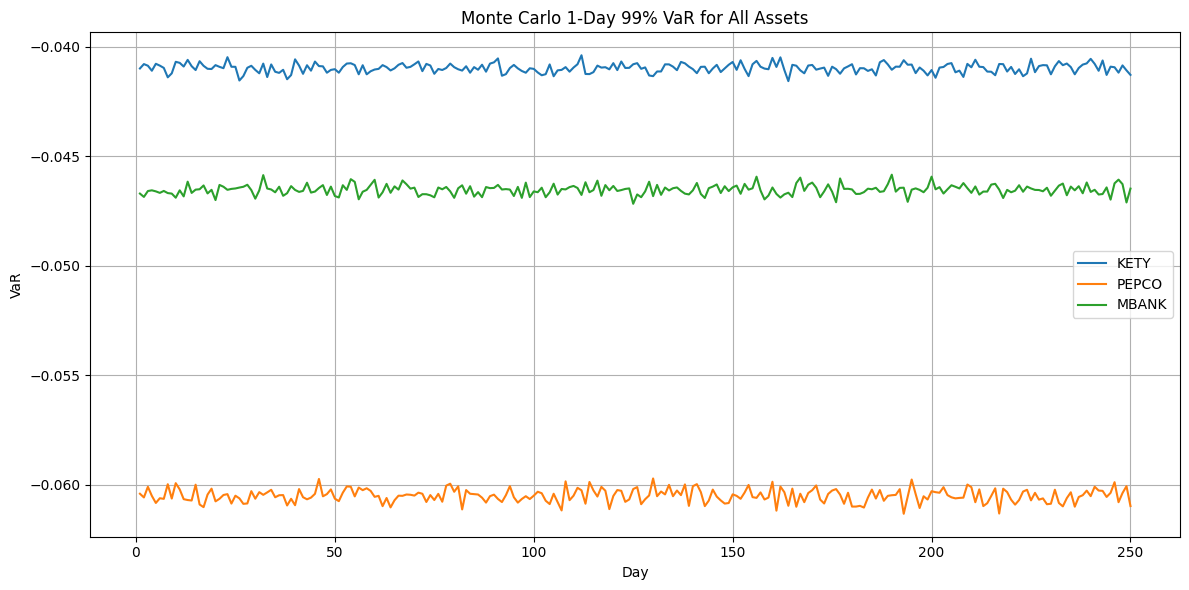

In [4]:
import matplotlib.pyplot as plt

# Jeden wykres dla wszystkich aktywów
plt.figure(figsize=(12, 6))

for asset in assets:
    col_name = f'{asset}_VaR_1d_99_MC'
    if col_name in montecarlo_var_all_assets.columns:
        plt.plot(
            montecarlo_var_all_assets.index, 
            montecarlo_var_all_assets[col_name], 
            label=asset
        )

plt.title('Monte Carlo 1-Day 99% VaR for All Assets')
plt.xlabel('Day')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Monte Carlo 1-Day 99% VaR for Individual Assets

The plot above presents the 1-day 99% Value at Risk (VaR) estimates for three assets (KETY, PEPCO, MBANK) calculated using the Monte Carlo simulation method. The key observations are:

- The VaR values for each asset remain relatively stable over the simulation horizon.
- This behavior is expected since the simulation parameters (mean return, volatility) are estimated based on a rolling historical window of 250 days and are held constant throughout the simulation.
- Minor fluctuations in the VaR values are natural due to the random nature of Monte Carlo simulations.
- PEPCO shows the highest risk (most negative VaR), while KETY has the lowest risk among the three assets.
- The differences between the assets' VaR levels reflect differences in their historical volatility and return characteristics.

Overall, the results seem consistent with the assumptions and methodology used for Monte Carlo VaR estimation.


# Backtesting and Basel II Capital Requirement: Individual Assets

In this section, we perform **backtesting** of the Monte Carlo 1-day 99% VaR for individual assets, and estimate the **Basel II regulatory capital requirement**.

### For this purpose we carry out the following procedure

- Simulate 1000 pseudo-realized paths by randomly selecting Monte Carlo scenarios.
- For each path:
  - Record the number of VaR breaches.
  - Perform Kupiec and Christoffersen statistical tests.
  - Calculate the Basel II capital requirement using an adjusted multiplier based on exceptions.
- Aggregate results to summarize model performance for each asset.


In [5]:
test_summary_assets_df.head()

,asset,kupiec_passed,kupiec_failed,christoffersen_passed,christoffersen_failed,basel_requirement_mean
0,KETY,911,89,92,908,-0.041292
1,MBANK,926,74,78,922,-0.046483
2,PEPCO,899,101,101,899,-0.060974


### Interpretation:

- The majority of Monte Carlo backtests for individual assets successfully pass the Kupiec test.  
- However, most assets fail the Christoffersen Independence test, indicating some clustering of exceptions.
- **MBANK** shows particularly strong performance in the Kupiec test, passing it approximately **92.6%** of the time.
- The average Basel II capital requirements across assets are relatively close to the average daily VaR estimates from the simulations, reflecting the fact that pseudo-realized paths are generated under consistent assumptions of geometric Brownian motion and constant volatility.

# Monte Carlo Simulation for Portfolio - VaR Estimation

We now simulate the entire portfolio by modeling correlated asset returns using the Cholesky decomposition of the correlation matrix.

Steps:
- Estimate mean returns and covariance matrix from the last 250 days.
- Simulate 100,000 paths of correlated log returns.
- Calculate the 1-day and 10-day 99% Monte Carlo VaR for the portfolio.

Each asset in the portfolio has an equal weight (1/3 each).

In [6]:
# Portfolio simulation setup
portfolio_value = 300000
test_moment = '2024-12-30'
sample_size_test = 250
sample_size_capital = 59
confidence_level = 0.99
alpha = 0.05
dt = 1 / 250
n_days = 251
n_scenarios = 100000

returns_subset = log_returns[assets]
dates_subset = returns_subset.loc[:test_moment].index[-sample_size_test:]
returns_sample = returns_subset.loc[dates_subset]

mu = returns_sample.mean().values
cov_matrix = returns_sample.cov().values
cor_matrix = returns_sample.corr().values
sigma = np.sqrt(np.diag(cov_matrix))

Z = np.random.normal(0, 1, size=(n_scenarios, n_days, len(assets)))
L = np.linalg.cholesky(cor_matrix)
Z_corr = Z @ L.T

mu_annualized = mu * 250
sigma_annualized = sigma * np.sqrt(250)
drift = (mu_annualized + 0.5 * sigma_annualized**2) * dt
shock = sigma_annualized * np.sqrt(dt)

log_returns_sim = drift + Z_corr * shock

initial_prices = np.array([portfolio_value / len(assets)] * len(assets))
prices_sim = np.zeros((n_scenarios, n_days + 1, len(assets)))
prices_sim[:, 0, :] = initial_prices

for t in range(1, n_days + 1):
    prices_sim[:, t, :] = prices_sim[:, t - 1, :] * np.exp(log_returns_sim[:, t - 1, :])

portfolio_values = prices_sim @ portfolio_weights
portfolio_log_returns = np.log(portfolio_values[:, 1:] / portfolio_values[:, :-1])

portfolio_var_1d_99_mc = np.percentile(portfolio_log_returns, 1, axis=0)
portfolio_var_10d_99_mc = portfolio_var_1d_99_mc * np.sqrt(10)

montecarlo_portfolio_var_df = pd.DataFrame({
    'PORTFOLIO_VaR_1d_99_MC': portfolio_var_1d_99_mc,
    'PORTFOLIO_VaR_10d_99_MC': portfolio_var_10d_99_mc,
}, index=range(1, n_days + 1))


## Simulated 10-Day 99% VaR for Assets and Portfolio
Plotting the VaR paths offers a clear way to visualize and assess the risk dynamics over time, including the portfolio’s 10-day 99% VaR alongside individual asset risks, highlighting the effects of diversification.

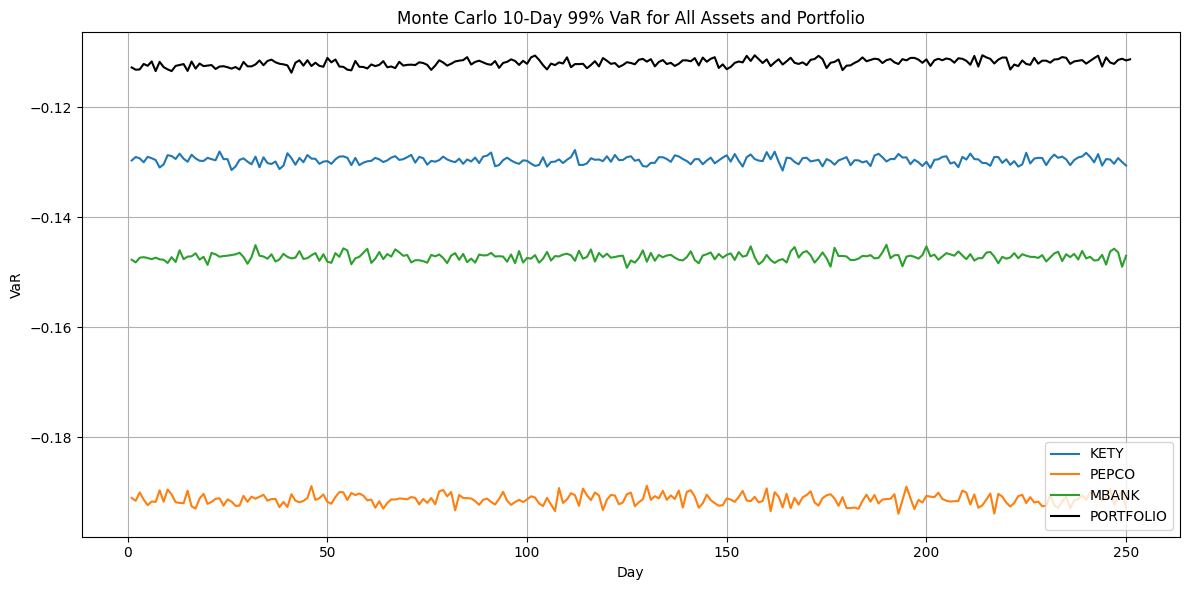

In [7]:
# Create one figure for all assets + portfolio VaR
plt.figure(figsize=(12, 6))

# Plot individual asset VaR
for asset in assets:
    col_name = f'{asset}_VaR_10d_99_MC'
    if col_name in montecarlo_var_all_assets.columns:
        plt.plot(
            montecarlo_var_all_assets.index, 
            montecarlo_var_all_assets[col_name], 
            label=asset
        )

# Plot portfolio VaR (10-day 99% MC)
plt.plot(
    montecarlo_portfolio_var_df.index, 
    montecarlo_portfolio_var_df['PORTFOLIO_VaR_10d_99_MC'], 
    label='PORTFOLIO', 
    color='black'
)

# Add plot decorations
plt.title('Monte Carlo 10-Day 99% VaR for All Assets and Portfolio')
plt.xlabel('Day')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Monte Carlo 10-Day 99% VaR for Assets and Portfolio

The plot above shows the simulated 10-day 99% Value at Risk (VaR) for three individual assets (KETY, PEPCO, MBANK) as well as for the overall portfolio.
As expected, the portfolio VaR is lower than the individual asset VaRs due to diversification effects.
This confirms that combining assets with different risk profiles leads to reduced overall portfolio risk compared to the standalone asset risks.

# Portfolio Backtesting and Basel II Capital Requirement

We perform backtesting by:
- Randomly selecting 1,000 simulated paths.
- Applying Kupiec's POF test and Christoffersen's Independence test.
- Estimating the Basel II capital requirement for each path using the historical exceptions and average VaR.

Results are summarized by aggregating across all 1,000 iterations.


In [8]:
montecarlo_portfolio_tests = []

for i in range(1000):
    idx = np.random.randint(0, n_scenarios)
    pseudo_real_returns = portfolio_log_returns[idx]

    exceptions = pd.Series((pseudo_real_returns < portfolio_var_1d_99_mc).astype(int))

    LR_POF, chi2_pof, n_exceptions = kupiec_test(exceptions, confidence_level, alpha)
    kupiec_pass = LR_POF < chi2_pof

    LR_CC, chi2_cc = christoffersen_test(exceptions, alpha)
    christoffersen_pass = LR_CC < chi2_cc

    pseudo_ret_sample = pseudo_real_returns[-sample_size_capital - 1:-1]
    var_sample = portfolio_var_1d_99_mc[-sample_size_capital - 1:-1]

    exceptions_cap = (pseudo_ret_sample < var_sample).astype(int)
    sredni_var = var_sample.mean()
    liczba_przekroczen = exceptions_cap.sum()
    wspolczynnik = assign_multiplier(liczba_przekroczen)

    var_dla_test_moment = portfolio_var_1d_99_mc[-1]
    basel_requirement = calculate_capital_requirement(var_dla_test_moment, sredni_var, wspolczynnik)

    montecarlo_portfolio_tests.append({
        'iteration': i,
        'kupiec_pass': kupiec_pass,
        'christoffersen_pass': christoffersen_pass,
        'n_exceptions': n_exceptions,
        'basel_requirement': basel_requirement
    })

montecarlo_portfolio_tests_df = pd.DataFrame(montecarlo_portfolio_tests)

portfolio_test_summary_df = pd.DataFrame([{
    'Asset': 'PORTFEL',
    'kupiec_passed': montecarlo_portfolio_tests_df['kupiec_pass'].sum(),
    'kupiec_failed': (~montecarlo_portfolio_tests_df['kupiec_pass']).sum(),
    'christoffersen_passed': montecarlo_portfolio_tests_df['christoffersen_pass'].sum(),
    'christoffersen_failed': (~montecarlo_portfolio_tests_df['christoffersen_pass']).sum(),
    'basel_requirement_mean': montecarlo_portfolio_tests_df['basel_requirement'].mean()
}])
portfolio_test_summary_df

,Asset,kupiec_passed,kupiec_failed,christoffersen_passed,christoffersen_failed,basel_requirement_mean
0,PORTFEL,920,80,77,923,-0.035178


## Interpretation for Portfolio
Compared to individual assets, the portfolio shows a slightly better performance in the Kupiec test, maintaining a high pass rate of 92%.
Similar to the assets, the portfolio largely fails the Christoffersen Independence test, indicating the presence of exception clustering.
Notably, the portfolio’s average Basel II capital requirement is less negative than for any individual asset, illustrating the risk-reducing effect of diversification.